In [1]:
import os
import subprocess
import collections
import re
import csv
import json
import math

import pandas as pd
import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import psycopg2
import requests
from imdbpie import Imdb
import nltk

import urllib
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

# set a random state to be used throughout
rs = 12

In [2]:
# connecting to IMDB API
imdb = Imdb()
imdb = Imdb(anonymize=True)

In [3]:
# Querying top 250 movies
movies = imdb.top_250()
movies[0:4]

[{u'can_rate': True,
  u'image': {u'height': 1388,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg',
   u'width': 933},
  u'num_votes': 1682803,
  u'rating': 9.3,
  u'tconst': u'tt0111161',
  u'title': u'The Shawshank Redemption',
  u'type': u'feature',
  u'year': u'1994'},
 {u'can_rate': True,
  u'image': {u'height': 500,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BMjEyMjcyNDI4MF5BMl5BanBnXkFtZTcwMDA5Mzg3OA@@._V1_.jpg',
   u'width': 333},
  u'num_votes': 1151252,
  u'rating': 9.2,
  u'tconst': u'tt0068646',
  u'title': u'The Godfather',
  u'type': u'feature',
  u'year': u'1972'},
 {u'can_rate': True,
  u'image': {u'height': 500,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BNDc2NTM3MzU1Nl5BMl5BanBnXkFtZTcwMTA5Mzg3OA@@._V1_.jpg',
   u'width': 333},
  u'num_votes': 787479,
  u'rating': 9,
  u'tconst': u'tt0071562',
  u'title': u'The Godfather: Part II',
  u'type': u'feature',
  u'year': u'1974'},
 {u'can_rate': True,
 

In [4]:
# Retrieving columns that I think will be useful 
top250 = pd.DataFrame(movies)[['num_votes','rating', 'tconst', 'title', 'year']]
top250.head()

,num_votes,rating,tconst,title,year
0,1682803,9.3,tt0111161,The Shawshank Redemption,1994
1,1151252,9.2,tt0068646,The Godfather,1972
2,787479,9.0,tt0071562,The Godfather: Part II,1974
3,1667685,9.0,tt0468569,The Dark Knight,2008
4,861274,8.9,tt0108052,Schindler's List,1993


In [5]:
top250.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
num_votes    250 non-null int64
rating       250 non-null float64
tconst       250 non-null object
title        250 non-null object
year         250 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 9.8+ KB


In [6]:
# select the top 100 movies
top100 = top250.sort_values('rating', ascending=False)[0:100]
top100.head()

,num_votes,rating,tconst,title,year
0,1682803,9.3,tt0111161,The Shawshank Redemption,1994
1,1151252,9.2,tt0068646,The Godfather,1972
2,787479,9.0,tt0071562,The Godfather: Part II,1974
3,1667685,9.0,tt0468569,The Dark Knight,2008
6,1318935,8.9,tt0110912,Pulp Fiction,1994


In [7]:
# function to convert string to list of strings, removing whitespace
# from start and end (to use for getting lists of genres)
def strtolist(string):
    result = []
    current = ""
    for c in string:
        if c == ",":
            result.append(current.strip())
            current=""
        else:
            current+=(c)
    result.append(current.strip())
    return result

In [8]:
# create dictionary of movie id: {dictionary of genres and runtimes}
# also create list of all genres across all movies
allgenres=[]
genreruntime = {}
for mID in top100.tconst:
    url = "http://www.omdbapi.com/?i="+mID
    data = urllib.urlopen(url)
    parsed_data = json.loads(data.read())
    genres = strtolist(parsed_data["Genre"])
    runtime = parsed_data["Runtime"]
    rt = int(runtime[0:(len(runtime)-4)])
    genreruntime[mID] = {'genres': genres, 'runtime': rt}
    for genre in genres:
        if genre not in allgenres:
            allgenres.append(genre)

In [9]:
# add columns for Runtime and Genres to dataframe
top100["runtime_mins"] = np.nan
for genre in allgenres:
    top100[genre] = 0

In [10]:
# populate our new columns with values for each movie
for mID in top100.tconst:
    i = top100[top100['tconst']==mID].index
    top100.set_value(i, 'runtime_mins', genreruntime[mID]['runtime'])
    for genre in genreruntime[mID]['genres']:
        top100.set_value(i, genre, 1)

In [11]:
# look at % of top 100 that genre constitutes (sum is >100% due to 
# some movies having multiple genres). Make sure all nonzero
top100[allgenres].sum().sort_values(ascending=False)/top100.tconst.count()

Drama        0.72
Crime        0.26
Adventure    0.25
Action       0.20
Mystery      0.13
Thriller     0.11
Comedy       0.11
Biography    0.09
Sci-Fi       0.08
Animation    0.07
Romance      0.07
Fantasy      0.07
War          0.07
Family       0.05
History      0.04
Western      0.04
Horror       0.04
Film-Noir    0.03
Music        0.01
Sport        0.01
dtype: float64

In [12]:
# change scifi and film noir column headers to avoid "-" char
top100.rename(columns = {'Sci-Fi': 'Sci_Fi', 'Film-Noir': 'Film_Noir'}, inplace=True)

In [13]:
# Write the Results to a csv
top100.to_csv('top100.csv', encoding='utf-8', index=False)

In [14]:
# use imdbpie to extract the reviews and ratings for each movie
top100reviews= {}
for mID in top100.tconst:
    reviews = imdb.get_title_reviews(mID, max_results=10000)
    revlist = []
    for review in reviews:
        revdict = {'revText': review.text, 'revRating': review.rating}
        revlist.append(revdict)
    top100reviews[mID] = revlist

In [15]:
print len(top100reviews)

100


In [16]:
# use regex to strip alphanumeric chars from each review and separately
# make list of all reviews
allReviews = []
for movie in top100reviews:
    for i in range(len(top100reviews[movie])):
        strippedText = re.sub(r'([^\s\w]|_)+', '', top100reviews[movie][i]['revText']).replace('\n', ' ')
        allReviews.append(strippedText)
        top100reviews[movie][i]['revText'] = strippedText
        

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvect = TfidfVectorizer(ngram_range = (1,2), stop_words='english', max_features=200)

In [18]:
# train tvect on all reviews
tdm = tvect.fit_transform(allReviews)

In [19]:
# merge the reviews and ratings by creating a 3-column dataframe 
# with movie, review text and rating

top100revDF = pd.DataFrame(columns = ['mID', 'revText', 'revRating'])

for movie in top100reviews:
    for i in range(len(top100reviews[movie])):
        review = top100reviews[movie][i]
        top100revDF = top100revDF.append(pd.DataFrame([[movie, review['revText'], 
            review['revRating']]], columns = ['mID', 'revText', 'revRating']), 
            ignore_index=True)

In [20]:
# change mID column to tconst, to line up with the top100 table

top100revDF['tconst'] = top100revDF['mID']
del top100revDF['mID']

In [21]:
# remove \r from reviews
top100revDF['revText'] = top100revDF['revText'].replace('\r', ' ').replace('\\n', ' ').replace('\\r',' ')

In [22]:
# remove null rows
nonnull = top100revDF.dropna()

In [23]:
# create a csv file 
#nonnull.to_csv('reviews.csv', encoding='utf-8', index=False)

In [24]:
%reload_ext sql

/Users/Tamara/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/Tamara/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [25]:
%%sql 
postgresql://localhost:5432/

u'Connected: None@'

In [26]:
%%sql
DROP TABLE IF EXISTS top100;
CREATE TABLE top100
(num_votes integer,
rating decimal,
tconst text,
title text,
year integer,
runtime_mins numeric,
Crime integer,
Drama integer,
Action integer,
Thriller integer,
Adventure integer,
Fantasy integer,
Western integer,
Biography integer,
History integer,
Romance integer,
Mystery integer,
Sci_Fi integer,
War integer,
Comedy integer,
Animation integer,
Family integer,
Horror integer,
Film_Noir integer,
Music integer,
Sport integer
);

COPY top100 FROM
'/Users/Tamara/top100.csv'
DELIMITER ',' CSV HEADER;


Done.
Done.
100 rows affected.


[]

In [27]:
%%sql
DROP TABLE IF EXISTS reviews;
CREATE TABLE reviews 
(revText text,
 revRating decimal,
 tconst text
);

COPY reviews FROM '/Users/Tamara/reviews.csv'
DELIMITER ',' CSV HEADER;


Done.
Done.
95937 rows affected.


[]

In [28]:
joined = %sql SELECT * FROM reviews JOIN top100 ON reviews."tconst"=top100."tconst";

95934 rows affected.


In [29]:
result = pd.DataFrame(joined, columns = (nonnull.columns).append(top100.columns))
result.head()

,revText,revRating,tconst,num_votes,rating,tconst,title,year,runtime_mins,Crime,...,Animation,Family,Comedy,War,Horror,Mystery,Thriller,Film_Noir,Music,Sport
0,httpswitchingreelscom20140128sundancereviewwhi...,10.0,tt2582802,395007,8.5,tt2582802,Whiplash,2014,107.0,0,...,0,0,0,0,0,0,0,0,1,0
1,Taking the festival circuit by storm since its...,10.0,tt2582802,395007,8.5,tt2582802,Whiplash,2014,107.0,0,...,0,0,0,0,0,0,0,0,1,0
2,After seeing Damien Chazelles Whiplash a film...,9.0,tt2582802,395007,8.5,tt2582802,Whiplash,2014,107.0,0,...,0,0,0,0,0,0,0,0,1,0
3,There is so many excellent great things to say...,10.0,tt2582802,395007,8.5,tt2582802,Whiplash,2014,107.0,0,...,0,0,0,0,0,0,0,0,1,0
4,I saw this about 24 hours ago at the Best of F...,9.0,tt2582802,395007,8.5,tt2582802,Whiplash,2014,107.0,0,...,0,0,0,0,0,0,0,0,1,0


In [30]:
# reading in the tables because I had to restart computer
nonnull = pd.read_csv('/Users/Tamara/reviews.csv')
top100 = pd.read_csv('/Users/Tamara/top100.csv')

In [31]:
## code in case of problems with the SQL data
df = top100.merge(nonnull)

In [32]:
df.columns

Index([u'num_votes', u'rating', u'tconst', u'title', u'year', u'runtime_mins',
       u'Crime', u'Drama', u'Action', u'Adventure', u'Western', u'Biography',
       u'History', u'Fantasy', u'Romance', u'Sci_Fi', u'Animation', u'Family',
       u'Comedy', u'War', u'Horror', u'Mystery', u'Thriller', u'Film_Noir',
       u'Music', u'Sport', u'revText', u'revRating'],
      dtype='object')

In [33]:
df.rename(columns = {'rating': 'avgRating'}, inplace=True)
# drop title and tconst since they won't be used for modeling
df.drop(['tconst', 'title'], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95934 entries, 0 to 95933
Data columns (total 26 columns):
num_votes       95934 non-null int64
avgRating       95934 non-null float64
year            95934 non-null int64
runtime_mins    95934 non-null float64
Crime           95934 non-null int64
Drama           95934 non-null int64
Action          95934 non-null int64
Adventure       95934 non-null int64
Western         95934 non-null int64
Biography       95934 non-null int64
History         95934 non-null int64
Fantasy         95934 non-null int64
Romance         95934 non-null int64
Sci_Fi          95934 non-null int64
Animation       95934 non-null int64
Family          95934 non-null int64
Comedy          95934 non-null int64
War             95934 non-null int64
Horror          95934 non-null int64
Mystery         95934 non-null int64
Thriller        95934 non-null int64
Film_Noir       95934 non-null int64
Music           95934 non-null int64
Sport           95934 non-null int64

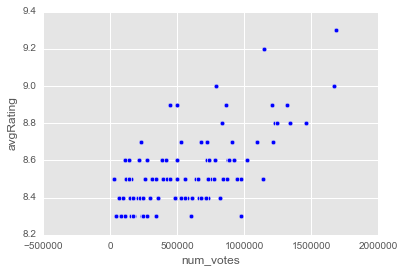

In [35]:
# do more votes correspond with higher avg rating?
plt.scatter(df['num_votes'], df['avgRating'])
plt.xlabel("num_votes")
plt.ylabel("avgRating")

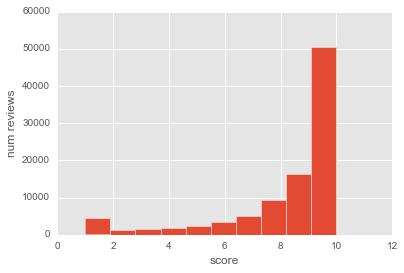

In [36]:
# What does distribution of ratings look like?
plt.hist(df['revRating'])
plt.xlabel("score")
plt.ylabel("num reviews")

In [37]:
# 1 seems to be most heavily used of low scores - when people dislike
# a movie they just score it at 1 rather than bother distinguishing between 1-4 (ish).
# Another interpretation is that people whose true opinion of a movie is middling
# (between, say, 2-7 rating equivalent) aren't as motivated to share their opinion as
# those who either loved or hated the movie.

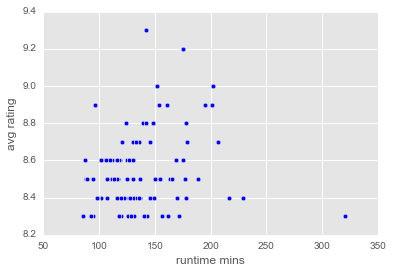

In [38]:
# look at avg rating vs runtime
plt.scatter(df['runtime_mins'], df['avgRating'])
plt.xlabel('runtime mins')
plt.ylabel('avg rating')

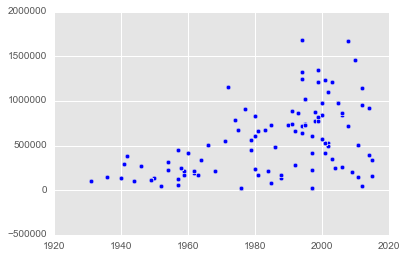

In [39]:
# num votes versus year (are fewer people voting on older movies?)
plt.scatter(df['year'], df['num_votes'])

In [40]:
df.columns

Index([u'num_votes', u'avgRating', u'year', u'runtime_mins', u'Crime',
       u'Drama', u'Action', u'Adventure', u'Western', u'Biography', u'History',
       u'Fantasy', u'Romance', u'Sci_Fi', u'Animation', u'Family', u'Comedy',
       u'War', u'Horror', u'Mystery', u'Thriller', u'Film_Noir', u'Music',
       u'Sport', u'revText', u'revRating'],
      dtype='object')

In [41]:
# define X, y
y = df['revRating']
X = df.drop(['num_votes', 'avgRating', 'revText', 'revRating'], axis=1)

In [42]:
y.head()

0    10.0
1    10.0
2    10.0
3     8.0
4    10.0
Name: revRating, dtype: float64

In [43]:
# Need to add tfidf columns to the dataset
dft = pd.DataFrame(tvect.transform(df['revText']).toarray(), columns = tvect.get_feature_names())

In [44]:
X = pd.concat([X, dft], axis = 1)

In [45]:
X.columns

Index([        u'year', u'runtime_mins',        u'Crime',        u'Drama',
             u'Action',    u'Adventure',      u'Western',    u'Biography',
            u'History',      u'Fantasy',
       ...
            u'watched',     u'watching',          u'way',    u'wonderful',
               u'work',        u'world',        u'worth',         u'year',
              u'years',        u'young'],
      dtype='object', length=222)

In [46]:
# there are 2 'year' columns, one for release year and one for the word 'year' in a review. Need to rename
newColHeaders = X.columns[1:].tolist()
newColHeaders.insert(0, "ReleaseYear")

In [47]:
X.columns = newColHeaders

In [48]:
# build and cross validate the tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
# instantiate classifier, use max_depth of 4 to control complexity
dt = DecisionTreeClassifier(max_depth = 4, random_state = rs)

In [50]:
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12, splitter='best')

In [51]:
cvscores = cross_val_score(dt, X, y, n_jobs = -1)
print cvscores
print cvscores.mean()

[ 0.52490386  0.46545955  0.51063364]
0.500332348019


In [52]:
# set up param grid
param_grid = {
    'max_depth': [None,2,4,6,8,10],
    'min_samples_split': range(5,100,10),
    'max_features': [None, 10, 100]
}

In [53]:
# instantiate gridsearchcv
gsdt = GridSearchCV(dt, param_grid, n_jobs=-1, verbose=1)

In [54]:
gsdt.fit(X,y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  7.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95], 'max_features': [None, 10, 100], 'max_depth': [None, 2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [55]:
gsdt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=100, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12, splitter='best')

In [56]:
cvscores = cross_val_score(gsdt.best_estimator_, X, y)
print cvscores
print cvscores.mean()

[ 0.52490386  0.49129062  0.52502033]
0.51373826644


In [57]:
gsdt_pred = gsdt.predict(X)
print classification_report(y, gsdt_pred)

             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      4358
        2.0       0.00      0.00      0.00      1361
        3.0       0.00      0.00      0.00      1648
        4.0       0.00      0.00      0.00      1750
        5.0       0.00      0.00      0.00      2445
        6.0       0.00      0.00      0.00      3332
        7.0       0.00      0.00      0.00      5182
        8.0       0.00      0.00      0.00      9247
        9.0       0.00      0.00      0.00     16249
       10.0       0.52      1.00      0.69     50362

avg / total       0.28      0.52      0.36     95934



/Users/Tamara/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
# Build and cross-validate your decision tree regressor
dtr = DecisionTreeRegressor(random_state=rs)

In [59]:
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best')

In [60]:
cvscores = cross_val_score(dtr, X, y)
print cvscores
print cvscores.mean()

[-0.5958467  -0.64055794 -0.70429368]
-0.646899438626


In [61]:
dtr_pred = dtr.predict(X)

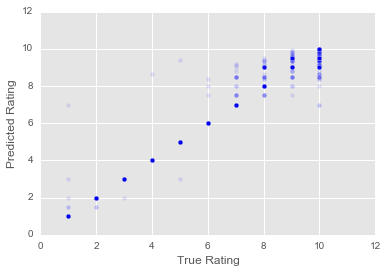

In [62]:
plt.scatter(y, dtr_pred, alpha=.1)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")

In [63]:
# instantiate gs, use same param grid as previous to see if theres improvement
gsdtr = GridSearchCV(dtr, param_grid, n_jobs=-1, verbose=1)

In [64]:
gsdtr.fit(X,y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95], 'max_features': [None, 10, 100], 'max_depth': [None, 2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [65]:
gsdtr.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=95,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best')

In [66]:
cvscores = cross_val_score(gsdtr.best_estimator_, X, y)
print cvscores
print cvscores.mean()

[ 0.09035395  0.11877692  0.04761802]
0.0855829668539


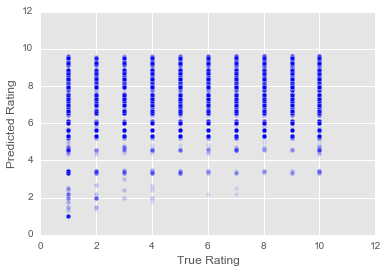

In [67]:
gsdtr_pred = gsdtr.predict(X)
plt.scatter(y, gsdtr_pred, alpha= .1)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")

In [68]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
rfr = RandomForestRegressor(random_state=rs, n_jobs=-1, verbose=1)
abr = AdaBoostRegressor(random_state=rs)
etr = ExtraTreesRegressor(random_state=rs,n_jobs=-1, verbose=1)

In [69]:
# Random Forest
# param_grid = {
#     'max_features': [None,5,20],
#     'max_depth':[None,5,10],
#     'min_samples_split': [2,10,40]
# }

param_grid = {'max_depth':[None,5,10]}

In [70]:
gsrfr = GridSearchCV(rfr, param_grid, verbose=1)

In [71]:
#grid search
gsrfr.fit(X,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_j

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=12,
           verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 5, 10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=1)

In [72]:
rfr.fit(X,y)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=12,
           verbose=1, warm_start=False)

In [73]:
abr.fit(X,y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=12)

In [74]:
rfr_cvscores = cross_val_score(rfr, X,y, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [75]:
abr_cvscores = cross_val_score(abr, X,y, n_jobs = -1)

In [76]:
etr_cvscores = cross_val_score(etr, X,y, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [77]:
print "Random Forest cvscore:", rfr_cvscores.mean()
print "AdaBoost cvscore:", abr_cvscores.mean()
print "ExtraTrees cvscore:", etr_cvscores.mean()

Random Forest cvscore: 0.103835103721
AdaBoost cvscore: -0.0355256404056
ExtraTrees cvscore: 0.106432403443


In [78]:
# use train_test_split and test performance
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

In [79]:
# fit models on training data
rfr.fit(X_train, y_train)
abr.fit(X_train, y_train)
etr.fit(X_train, y_train)
dtr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   50.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   50.2s finished


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best')

In [80]:
rfr_pred_test = rfr.predict(X_test)
abr_pred_test = abr.predict(X_test)
etr_pred_test = etr.predict(X_test)
dtr_pred_test = dtr.predict(X_test)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [81]:
# look at RMSE for each model - also compare with our decision tree regressor that performed OK-ish earlier
print "RFR RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(rfr_pred_test, y_test)])
print "ABR RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(abr_pred_test, y_test)])
print "ETR RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(etr_pred_test, y_test)])
print "Decision Tree RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(dtr_pred_test, y_test)])

RFR RMSE:  5.07554110949
ABR RMSE:  6.33869842379
ETR RMSE:  4.94647766972
Decision Tree RMSE:  9.24213084091


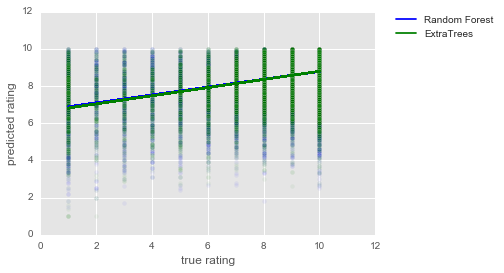

In [82]:
# ETR and RFR performed the best: look at them on a plot
plt.scatter(y_test, rfr_pred_test, c = 'blue', alpha = .05)
m_rtr, b_rtr = np.polyfit(y_test, rfr_pred_test, 1)
plt.plot(y_test, y_test*m_rtr+b_rtr, c='blue')
plt.scatter(y_test, etr_pred_test, c = 'green', alpha = .05)
m_etr, b_etr = np.polyfit(y_test, etr_pred_test, 1)
plt.plot(y_test, y_test*m_etr+b_etr, c='green')
plt.xlabel("true rating")
plt.ylabel("predicted rating")
plt.legend(['Random Forest', 'ExtraTrees'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

These models are generally overestimating ratings. It is possible that this is due in part to our data being so skewed to high ratings: we simply don't have sufficient training data to learn how to predict low ratings. Given that our data mostly has high ratings, our model is correctly predicting higher ratings generally because they're more likely to be correct. A better training set would have an equal distribution of true ratings.

In [83]:
# taking the important features from the Random Forest regressor and putting them into a dataframe
importances = pd.DataFrame(zip(X.columns, rfr.feature_importances_), columns = ['Variable', 
    'Importance']).sort_values('Importance', ascending = False)

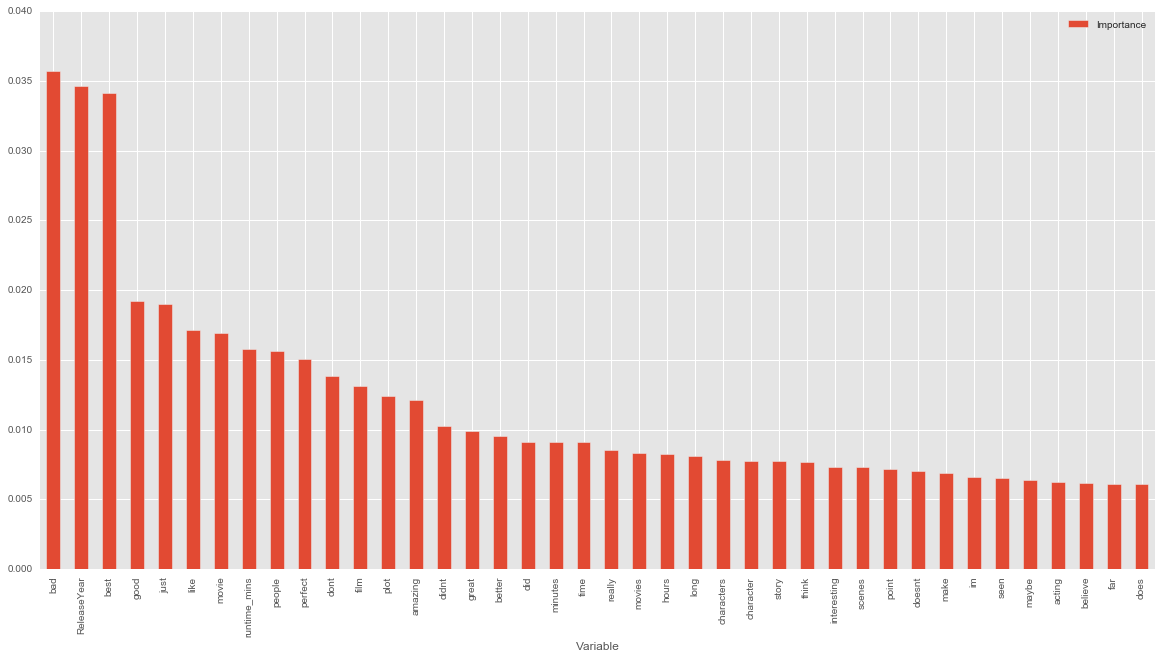

In [84]:
# plot only top 40 features to avoid cluttering
importances.head(40).plot(kind='bar', x = 'Variable', y = 'Importance', figsize = (20,10))